## L98-59 Modelling

This notebook will contain the analysis of the L98-59 system. This project utilises data from HARPS and ESPRESSO, the analysis will be done using the RadVel package. 

### Get the data

##### HARPS data

$\bold{\text{Program IDs:}}$ 198.C-0838, 1102.C-0339, and 0102.C-0525

$\bold{\text{Observation Dates:}}$ Between October 17, 2018 (BJD = 2458408.5) and April 28, 2019 (BJD = 2458601.5)

##### ESPRESSO data

$\bold{\text{Program IDs:}}$  1102.C-0744, 1102.C-0958, and 1104.C-0350

$\bold{\text{Observation Dates:}}$ Between November 14, 2018 (BJD = 2458436.5), and March 4, 2020
(BJD = 2458912.5)


##### Data Access
https://archive.eso.org/cms.html

In [2]:
import emcee
import george
import corner
import numpy as np
import pandas as pd
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from george import kernels
from george.modeling import Model
from scipy.optimize import minimize
from astropy.timeseries import LombScargle

### ESPRESSO Unpack Data

In [3]:
# Define the column titles - Time (BJD-2457000)
column_titles = [
    'Time', 'RV', 'e_RV', 'FWHM', 'e_FWHM', 'BIS', 'e_BIS', 'Contrast', 'e_Contrast', 'Sindex', 'e_Sindex', 
    'Halpha', 'e_Halpha', 'NaD', 'e_NaD', 'BERV', 'Inst'
]

# load data
espresso_df = pd.read_csv('J_A+A_653_A41/espresso.dat', delim_whitespace=True, names=column_titles)

time_pre = espresso_df['Time'].copy()

# Adjust the time column to BJD by adding 2400000
espresso_df['Time'] += 2400000

espresso_df.info()
espresso_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time        66 non-null     float64
 1   RV          66 non-null     float64
 2   e_RV        66 non-null     float64
 3   FWHM        66 non-null     float64
 4   e_FWHM      66 non-null     float64
 5   BIS         66 non-null     float64
 6   e_BIS       66 non-null     float64
 7   Contrast    66 non-null     float64
 8   e_Contrast  66 non-null     float64
 9   Sindex      66 non-null     float64
 10  e_Sindex    66 non-null     float64
 11  Halpha      66 non-null     float64
 12  e_Halpha    66 non-null     float64
 13  NaD         66 non-null     float64
 14  e_NaD       66 non-null     float64
 15  BERV        66 non-null     float64
 16  Inst        66 non-null     object 
dtypes: float64(16), object(1)
memory usage: 8.9+ KB


,Time,RV,e_RV,FWHM,e_FWHM,BIS,e_BIS,Contrast,e_Contrast,Sindex,e_Sindex,Halpha,e_Halpha,NaD,e_NaD,BERV,Inst
0,2.458437e+06,-5573.437416,0.816913,4499.263409,1.633825,20.033978,1.633825,42.799587,0.015542,0.598479,0.002542,0.600940,0.000142,0.067823,0.000083,3.416847,Pre
1,2.458445e+06,-5576.693982,0.793815,4498.810086,1.587631,19.357431,1.587631,42.597043,0.015033,0.688857,0.002322,0.596644,0.000139,0.073309,0.000082,4.175202,Pre
2,2.458464e+06,-5580.193552,0.653161,4507.480887,1.306323,20.522430,1.306323,42.765184,0.012394,0.672483,0.001731,0.600782,0.000109,0.064390,0.000062,5.718515,Pre
3,2.458471e+06,-5579.244790,0.676495,4503.037787,1.352990,16.917991,1.352990,42.717744,0.012835,0.613767,0.001831,0.616538,0.000113,0.061649,0.000064,6.179283,Pre
4,2.458489e+06,-5578.568851,1.060688,4510.972651,2.121377,22.321148,2.121377,42.689840,0.020076,0.714336,0.003768,0.602749,0.000190,0.068562,0.000113,6.850254,Pre


### Exlcude Specific Measurements

In [4]:
# Remove datapoints as performed in paper
'''
From the 66 measurements, we discarded three measurements, obtained at 2 458 645.496, 2 458 924.639, and
2 458 924.645 BJDTDB, due to their high RV uncertainties (identified through an iterative 4σ clipping). 
'''

# Define the BJDs to be excluded
excluded_bjds = [2458645.496, 2458924.639, 2458924.645] 

# add tolerance
tolerance = 1e-3

# Exclude the specified BJDs
cleaned_df = espresso_df[~espresso_df['Time'].apply(lambda x: any(abs(x - bjd) < tolerance for bjd in excluded_bjds))]

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 0 to 65
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Time        63 non-null     float64
 1   RV          63 non-null     float64
 2   e_RV        63 non-null     float64
 3   FWHM        63 non-null     float64
 4   e_FWHM      63 non-null     float64
 5   BIS         63 non-null     float64
 6   e_BIS       63 non-null     float64
 7   Contrast    63 non-null     float64
 8   e_Contrast  63 non-null     float64
 9   Sindex      63 non-null     float64
 10  e_Sindex    63 non-null     float64
 11  Halpha      63 non-null     float64
 12  e_Halpha    63 non-null     float64
 13  NaD         63 non-null     float64
 14  e_NaD       63 non-null     float64
 15  BERV        63 non-null     float64
 16  Inst        63 non-null     object 
dtypes: float64(16), object(1)
memory usage: 8.9+ KB


In [5]:
# update index
cleaned_df.index = range(len(cleaned_df))

# inspect removed data
espresso_df[espresso_df['Time'].apply(lambda x: any(abs(x - bjd) < tolerance for bjd in excluded_bjds))]

,Time,RV,e_RV,FWHM,e_FWHM,BIS,e_BIS,Contrast,e_Contrast,Sindex,e_Sindex,Halpha,e_Halpha,NaD,e_NaD,BERV,Inst
39,2.458645e+06,-5573.412499,2.593186,4516.243761,5.186372,11.796432,5.186372,42.311253,0.048589,0.630196,0.013261,0.618375,0.000464,0.091398,0.000309,-5.672763,Pre
61,2.458925e+06,-24318.548980,106.668517,15109.631376,213.337034,10221.017675,213.337034,15.139146,0.213754,1.270314,0.027503,-5.215018,0.022910,-0.435390,0.015269,3.188847,Post
62,2.458925e+06,-5542.275981,2.288525,4392.156450,4.577050,18.569121,4.577050,39.677488,0.041348,0.291169,0.020190,0.577276,0.000403,0.101922,0.000283,3.183276,Post


### Generalised Lomb-Scargle Periodogram (GLSP)

In [6]:
time = cleaned_df['Time']

min_frequency = 1 / (time.max() - time.min())  # Longest period
max_frequency = 1 / (2 * np.median(np.diff(time)))  # Nyquist frequency

print(f'Minimum frequency: {min_frequency:}')
print(f'Maximum frequency: {max_frequency:}')

Minimum frequency: 0.002025227467386652
Maximum frequency: 0.1436295790411789


The biggest frequency ange between HARPS ans ESPRESSO was used (days^-1):

Minimum frequency (ESPRESSO) = 0.002025227467386652

Maximum frequency (HARPS) = 0.5173265598042253

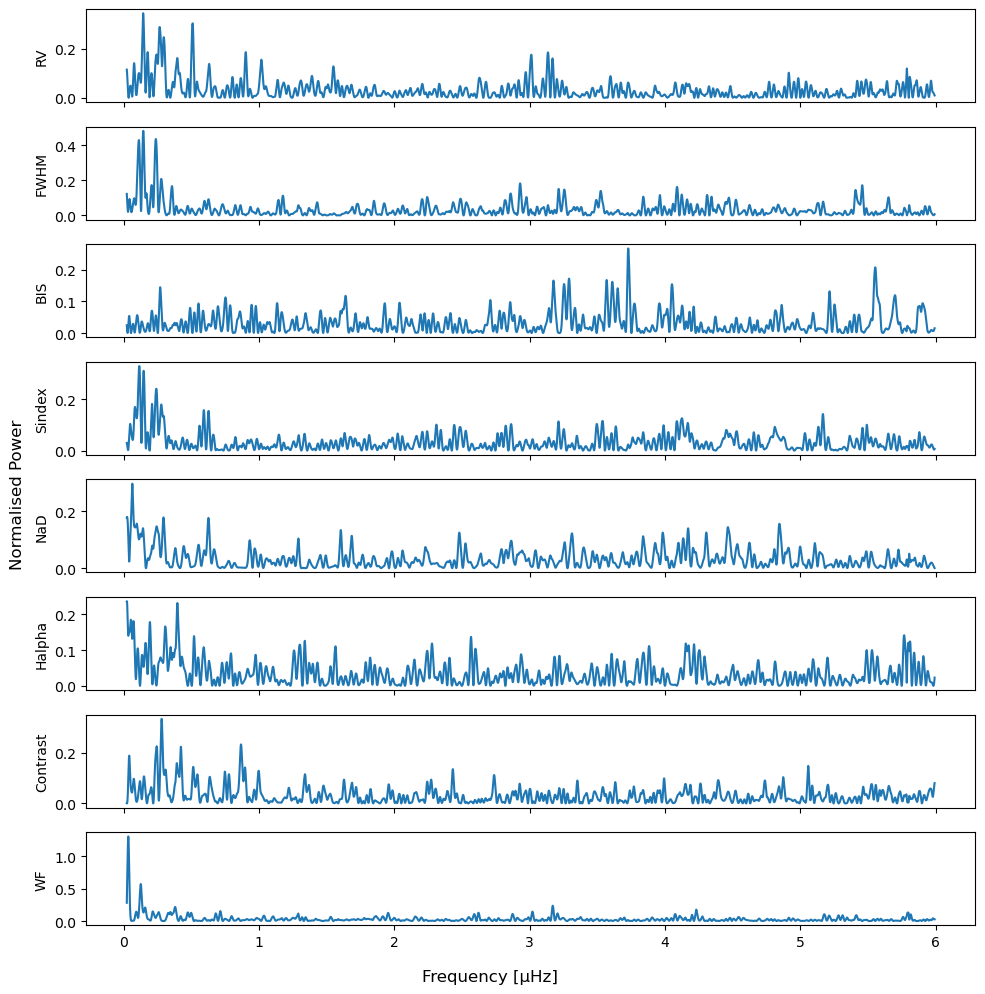

In [7]:
# Extract data
time = cleaned_df['Time']
activity_indices = ['RV', 'FWHM', 'BIS', 'Sindex', 'NaD', 'Halpha', 'Contrast']

# Determine the frequency range days
# min_frequency = 1 / (time.max() - time.min())  # Longest period
min_frequency = 0.002025227467386652 # min frequency ESPRESSO
#min_frequency = 0.0036063525167432157
max_frequency = 0.5177264355163222   # max frequency HARPS
samples_per_peak = 3000

# convert frequency to microhertz
def convert_to_microhertz(frequency_in_days):
    return frequency_in_days * 1e6 / 86400

# Perform the Lomb-Scargle periodogram
def compute_periodogram(time, data, min_frequency=min_frequency, max_frequency=max_frequency, samples_per_peak=samples_per_peak):

    frequency, power = LombScargle(time, data).autopower(
        minimum_frequency=min_frequency,
        maximum_frequency=max_frequency,
        normalization='standard',
        samples_per_peak=samples_per_peak
        )
    return frequency, power

# Compute periodograms
periodograms = {}
for index in activity_indices:
    frequency, power = compute_periodogram(time, cleaned_df[index], min_frequency, max_frequency)
    periodograms[index] = (frequency, power)

# Compute the window function
observation_indicator = np.ones_like(time)
window_power = LombScargle(time, observation_indicator).power(frequency)
periodograms['WF'] = (frequency, window_power)  # Add the window function to the periodograms


# Plotting
fig, axes = plt.subplots(len(periodograms), 1, figsize=(10, 10), sharex=True)

for ax, (key, (frequency, power)) in zip(axes, periodograms.items()):
    ax.plot(convert_to_microhertz(frequency), power)
    ax.set_ylabel(key)

# common axis labels
fig.supxlabel('Frequency [µHz]')
fig.supylabel('Normalised Power')

plt.tight_layout()
plt.show()

In [8]:
# True values (accoridng to paper (D. S. Demangeon et al. 2021))
true_periods = [2.2531136, 3.6906777,  7.4507245, 12.796]

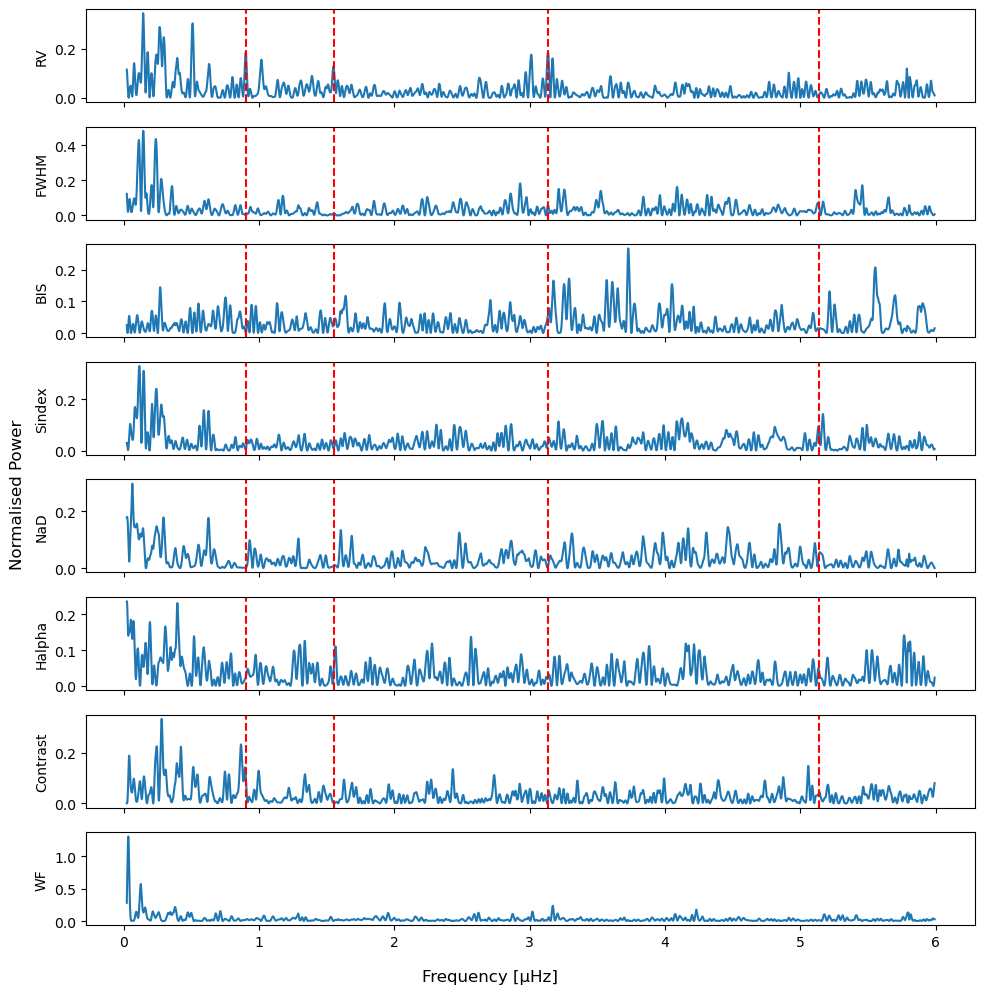

In [9]:
# Plotting
fig, axes = plt.subplots(len(periodograms), 1, figsize=(10, 10), sharex=True)

for i, (ax, (key, (frequency, power))) in enumerate(zip(axes, periodograms.items())):
    ax.plot(convert_to_microhertz(frequency), power)
    ax.set_ylabel(key)
    if i < len(axes) - 1:
        for peak in true_periods:
            ax.axvline(x=convert_to_microhertz(1 / peak), color='r', linestyle='--')

# common axis labels
fig.supxlabel('Frequency [µHz]')
fig.supylabel('Normalised Power')

plt.tight_layout()
plt.show()

### $log R^{'}_{\text{HK}} $ timeseries (S-index)

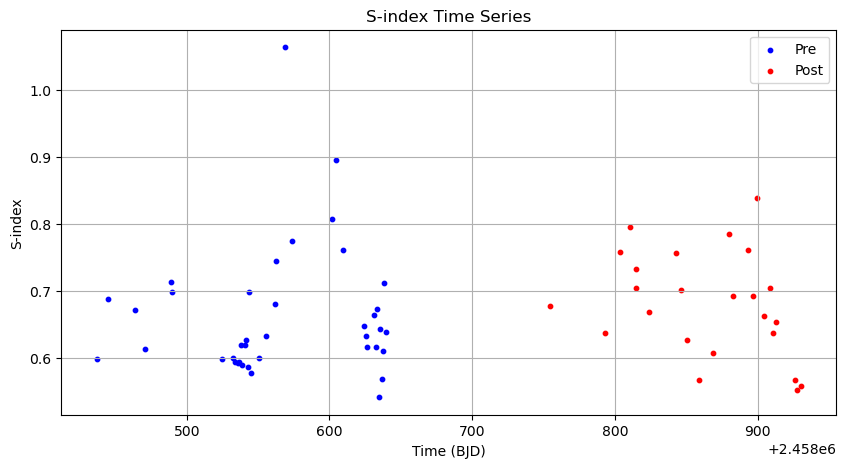

In [10]:
# seperate data for pre and post intervention
df_pre = cleaned_df[cleaned_df['Inst'] == 'Pre']
df_post = cleaned_df[cleaned_df['Inst'] == 'Post']

# Visualise s-index time series
plt.figure(figsize=(10, 5))
plt.scatter(df_pre['Time'], df_pre['Sindex'], s=10, c='blue', label='Pre')
plt.scatter(df_post['Time'], df_post['Sindex'], s=10, c='red', label='Post')
plt.xlabel('Time (BJD)')
plt.ylabel('S-index')
plt.title('S-index Time Series')
plt.grid(True)
plt.legend()
plt.show()

## Fit GP to S-index
### pre

In [11]:
# Save the DataFrame to a CSV file (optional)
df_pre.to_csv('espresso_pre.csv', index=False)

In [12]:
# Data
time_pre = df_pre['Time']
s_index_values_pre = df_pre['Sindex']
s_index_error_pre = df_pre['e_Sindex']


'''# Rescale time for numerical stability
time = (time_pre - np.min(time_pre)) / 100.0'''

# Hyperparameters: amplitude, decay scale, periodicity scale, period
A = 0.2  # Amplitude
l = 40.0  # Decay timescale
Gamma = 1.0  # Periodic amplitude
P = 2  # Period

# Define the compostie kernel
kernel_pre = A * kernels.ExpSquaredKernel(metric=l**2) * \
         kernels.ExpSine2Kernel(gamma=Gamma, log_period=np.log(P))
    
# Initialise the GP
gp_pre = george.GP(kernel_pre)

# Optimisation functions
def nll_pre(p):
    gp_pre.set_parameter_vector(p)
    ll = gp_pre.log_likelihood(s_index_values_pre, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

def grad_nll_pre(p):
    gp_pre.set_parameter_vector(p)
    return -gp_pre.grad_log_likelihood(s_index_values_pre, quiet=True)

# Compute the initial guess
gp_pre.compute(time_pre, s_index_error_pre)
print("Initial ln-likelihood: {0:.2f}".format(gp_pre.log_likelihood(s_index_values_pre)))

# Optimisation routine
p0 = gp_pre.get_parameter_vector()
result = minimize(nll_pre, p0, jac=grad_nll_pre, method='L-BFGS-B')
print(result)

# Update the GP with the optimised parameters
gp_pre.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp_pre.log_likelihood(s_index_values_pre)))

Initial ln-likelihood: -2280.48
      fun: -20.845667013950806
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.07885023e-07,  8.73058980e-07, -5.27192788e-06,  3.96381562e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 44
      nit: 36
     njev: 44
   status: 0
  success: True
        x: array([-1.50395073,  7.12775765,  1.32102839,  1.71616187])

Final ln-likelihood: 20.85


In [13]:
# After the optimization has completed
optimized_parameters = gp_pre.get_parameter_vector()

# Print the optimized hyperparameters
print("Optimised Hyperparameters:")
print("Amplitude (A):", np.exp(optimized_parameters[0]))
print("Decay Timescale (l):", np.sqrt(np.exp(optimized_parameters[1])))
print("Periodic Amplitude (Gamma):", np.exp(optimized_parameters[2]))
print("Period (P):", np.exp(optimized_parameters[3]))

Optimised Hyperparameters:
Amplitude (A): 0.22225037220641075
Decay Timescale (l): 35.29985392592027
Periodic Amplitude (Gamma): 3.74727305727397
Period (P): 5.563135388547851


### MCMC to tune the GP hyperparameters

In [14]:
# Define log likelihood
def lnprob_pre(p):
    # Update the kernel and compute the lnlikelihood.
    gp_pre.set_parameter_vector(p)
    ll = gp_pre.log_likelihood(s_index_values_pre, quiet=True)
    # Simple flat prior: log(1) if in bounds, log(0) otherwise
    if np.any((-10 > p) | (p > 10)):
        return -np.inf  # log(0)
    return ll if np.isfinite(ll) else -1e25

# Set up the sampler.
nwalkers, ndim = 302, len(gp_pre)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_pre)

# Initialize the walkers.
p0 = [gp_pre.get_parameter_vector() + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

# Run MCMC.
print("Running MCMC...")
sampler.run_mcmc(p0, 5000, progress=True)
print("Done.")

Running MCMC...


100%|██████████| 5000/5000 [02:52<00:00, 28.93it/s]

Done.


Pre Mean Hyperparameters:
Amplitude (A): 0.22746670103723524
Decay Timescale (l): 33.88284942717069
Periodic Amplitude (Gamma): 4.053889863515153
Period (P): 5.5674512174453605


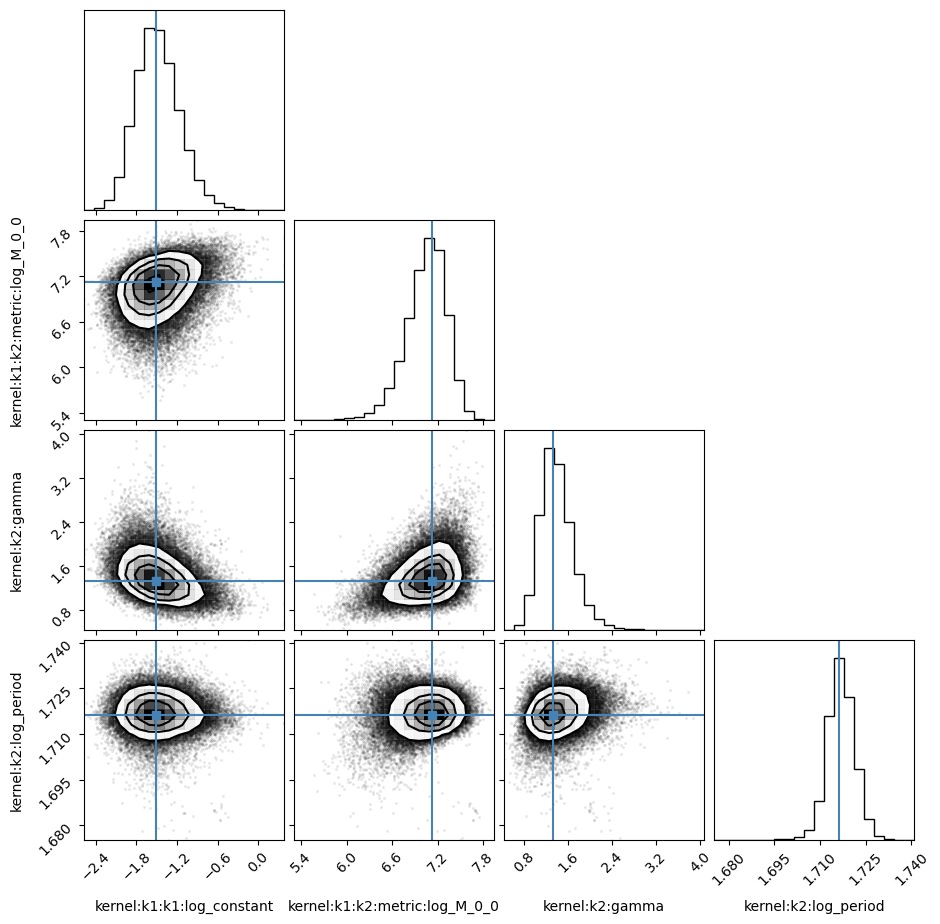

In [15]:
samples = sampler.get_chain(discard=1000, thin=15, flat=True)

figure = corner.corner(samples, labels=gp_pre.get_parameter_names(), truths=optimized_parameters)

# Mean and covariance of the samples can be used to initialize the GP.
gp_mean_pre = np.mean(samples, axis=0)
gp_pre.set_parameter_vector(gp_mean_pre)

print("Pre Mean Hyperparameters:")
print("Amplitude (A):", np.exp(gp_mean_pre[0]))
print("Decay Timescale (l):", np.sqrt(np.exp(gp_mean_pre[1])))
print("Periodic Amplitude (Gamma):", np.exp(gp_mean_pre[2]))
print("Period (P):", np.exp(gp_mean_pre[3]))

### Visualise the GP fit

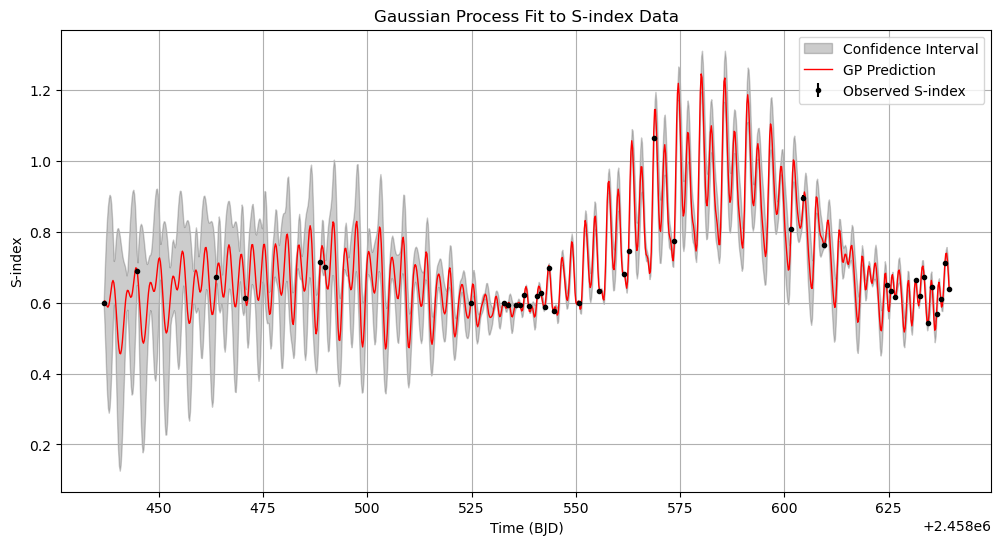

In [16]:
# Prediction points
t_pred_pre = np.linspace(min(time_pre), max(time_pre), 1000)  # 1000 points for smoothness
pred_pre, pred_var_pre = gp_pre.predict(s_index_values_pre, t_pred_pre, return_var=True) 

# Plot
plt.figure(figsize=(12, 6))
plt.fill_between(t_pred_pre, pred_pre - np.sqrt(pred_var_pre), pred_pre + np.sqrt(pred_var_pre), color="k", alpha=0.2, label='Confidence Interval')
plt.plot(t_pred_pre, pred_pre, 'r', lw=1, label='GP Prediction')
plt.errorbar(time_pre, s_index_values_pre, yerr=s_index_error_pre, fmt=".k", capsize=0, label='Observed S-index')
plt.xlabel('Time (BJD)')
plt.ylabel('S-index')
plt.title('Gaussian Process Fit to S-index Data')
plt.legend()
plt.grid(True)
plt.show()

### post

In [17]:
# Save the DataFrame to a CSV file (optional)
df_post.to_csv('espresso_post.csv', index=False)

In [18]:
# Data
time_post = df_post['Time']
s_index_values_post = df_post['Sindex']
s_index_error_post = df_post['e_Sindex']

'''# Rescale time for numerical stability
time = (time_post - np.min(time_post)) / 100.0'''

# Hyperparameters: amplitude, decay scale, periodicity scale, period
A = 0.2  # Amplitude
l = 30.0  # Decay timescale
Gamma = 4.0  # Periodic amplitude
P = 4  # Period

# Define the compostie kernel
kernel = A * kernels.ExpSquaredKernel(metric=l**2) * \
         kernels.ExpSine2Kernel(gamma=Gamma, log_period=np.log(P))
    
# Initialise the GP
gp_post = george.GP(kernel)

# Optimisation functions
def nll_post(p):
    gp_post.set_parameter_vector(p)
    ll = gp_post.log_likelihood(s_index_values_post, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

def grad_nll_post(p):
    gp_post.set_parameter_vector(p)
    return -gp_post.grad_log_likelihood(s_index_values_post, quiet=True)

# Compute the initial guess
gp_post.compute(time_post, s_index_error_post)
print("Initial ln-likelihood: {0:.2f}".format(gp_post.log_likelihood(s_index_values_post)))

# Optimisation routine
p0 = gp_post.get_parameter_vector()
result = minimize(nll_post, p0, jac=grad_nll_post, method='L-BFGS-B')
print(result)

# Update the GP with the optimised parameters
gp_post.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp_post.log_likelihood(s_index_values_post)))

Initial ln-likelihood: -11.45
      fun: -15.651521785003016
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.82720155e-01,  2.34156027e-01,  2.81914540e+00, -1.04085196e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 83
      nit: 51
     njev: 83
   status: 0
  success: True
        x: array([-1.60100471,  8.42052268,  1.92552131,  0.37148431])

Final ln-likelihood: 15.65


In [19]:
# After the optimization has completed
optimized_parameters = gp_post.get_parameter_vector()

# Print the optimized hyperparameters
print("Optimised Hyperparameters:")
print("Amplitude (A):", np.exp(optimized_parameters[0]))
print("Decay Timescale (l):", np.sqrt(np.exp(optimized_parameters[1])))
print("Periodic Amplitude (Gamma):", np.exp(optimized_parameters[2]))
print("Period (P):", np.exp(optimized_parameters[3]))

Optimised Hyperparameters:
Amplitude (A): 0.20169377264407176
Decay Timescale (l): 67.37414504658555
Periodic Amplitude (Gamma): 6.85872323294874
Period (P): 1.4498850954871843


### MCMC to tune the GP hyperparameters

In [20]:
# Define log likelihood
def lnprob_post(p):
    # Update the kernel and compute the lnlikelihood.
    gp_post.set_parameter_vector(p)
    ll = gp_post.log_likelihood(s_index_values_post, quiet=True)
    # Simple flat prior: log(1) if in bounds, log(0) otherwise
    if np.any((-10 > p) | (p > 10)):
        return -np.inf  # log(0)
    return ll if np.isfinite(ll) else -1e25

# Set up the sampler.
nwalkers, ndim = 302, len(gp_post)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_post)

# Initialize the walkers.
p0 = [gp_post.get_parameter_vector() + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

# Run MCMC.
print("Running MCMC...")
sampler.run_mcmc(p0, 5000, progress=True)
print("Done.")

Running MCMC...


100%|██████████| 5000/5000 [02:28<00:00, 33.64it/s]

Done.


Post Mean Hyperparameters:
Amplitude (A): 0.24574184650153136
Decay Timescale (l): 66.87117405493316
Periodic Amplitude (Gamma): 5.265295922403231
Period (P): 1.451198315402696


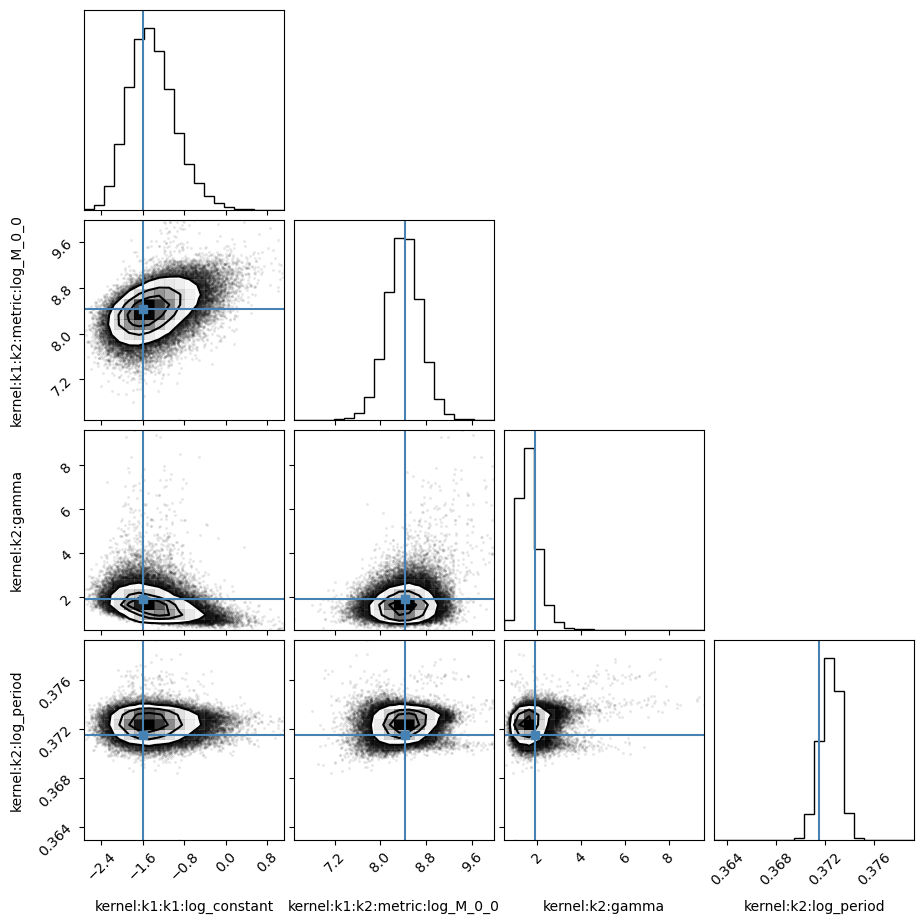

In [21]:
samples = sampler.get_chain(discard=1000, thin=15, flat=True)

figure = corner.corner(samples, labels=gp_post.get_parameter_names(), truths=optimized_parameters)

# Mean and covariance of the samples can be used to initialize the GP.
gp_mean_post = np.mean(samples, axis=0)
gp_post.set_parameter_vector(gp_mean_post)

print("Post Mean Hyperparameters:")
print("Amplitude (A):", np.exp(gp_mean_post[0]))
print("Decay Timescale (l):", np.sqrt(np.exp(gp_mean_post[1])))
print("Periodic Amplitude (Gamma):", np.exp(gp_mean_post[2]))
print("Period (P):", np.exp(gp_mean_post[3]))

#### Visualise

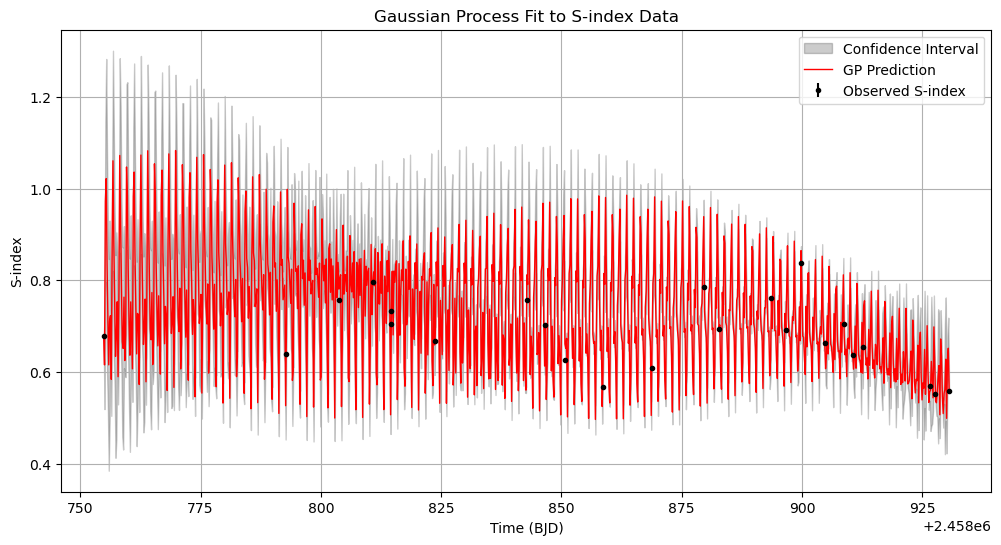

In [22]:
# Prediction points
t_pred_post = np.linspace(min(time_post), max(time_post), 1000)  # 1000 points for smoothness
pred_post, pred_var_post = gp_post.predict(s_index_values_post, t_pred_post, return_var=True) 

# Plot
plt.figure(figsize=(12, 6))
plt.fill_between(t_pred_post, pred_post - np.sqrt(pred_var_post), pred_post + np.sqrt(pred_var_post), color="k", alpha=0.2, label='Confidence Interval')
plt.plot(t_pred_post, pred_post, 'r', lw=1, label='GP Prediction')
plt.errorbar(time_post, s_index_values_post, yerr=s_index_error_post, fmt=".k", capsize=0, label='Observed S-index')
plt.xlabel('Time (BJD)')
plt.ylabel('S-index')
plt.title('Gaussian Process Fit to S-index Data')
plt.legend()
plt.grid(True)
plt.show()

## HARPS S-index for hierarchical model

In [23]:
# import cleaned HARPS data
harps_df = pd.read_csv('../HARPS/cleaned_harps_data.csv')

### HARPS S-index GP fit

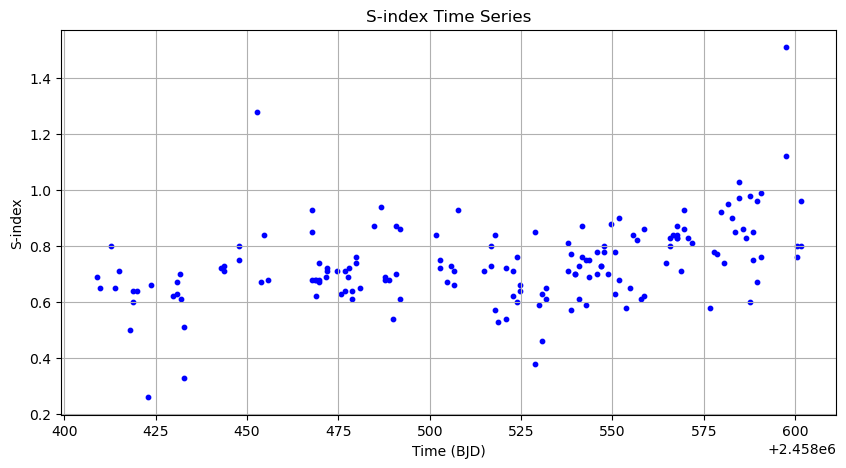

In [24]:
# Visualise s-index time series
plt.figure(figsize=(10, 5))
plt.scatter(harps_df['Time'], harps_df['Sindex'], s=10, c='blue')
plt.xlabel('Time (BJD)')
plt.ylabel('S-index')
plt.title('S-index Time Series')
plt.grid(True)
plt.show()

In [25]:
# Data
time = harps_df['Time']
s_index_values = harps_df['Sindex']
s_index_error = harps_df['e_Sindex']


# Hyperparameters: amplitude, decay scale, periodicity scale, period
A = 0.2  # Amplitude
l = 36.0  # Decay timescale
Gamma = 2.0  # Periodic amplitude
P = 2.0  # Period

# Define the compostie kernel
kernel = A * kernels.ExpSquaredKernel(metric=l**2) * \
         kernels.ExpSine2Kernel(gamma=Gamma, log_period=np.log(P))

# Initialise the GP
gp = george.GP(kernel)

# Optimisation functions
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(s_index_values, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(s_index_values, quiet=True)

# Compute the initial guess
gp.compute(time, s_index_error)
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(s_index_values)))

# Optimisation routine
p0 = gp.get_parameter_vector()
result = minimize(nll, p0, jac=grad_nll, method='L-BFGS-B')
print(result)

# Update the GP with the optimised parameters
gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(s_index_values)))

Initial ln-likelihood: 58.05
      fun: -80.15409203890492
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.06901552e-07, -2.27848841e-06, -3.93613169e-06, -2.02120966e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 59
      nit: 43
     njev: 59
   status: 0
  success: True
        x: array([-1.33630335,  9.00000143,  0.67347833,  0.71150202])

Final ln-likelihood: 80.15


In [26]:
# After the optimization has completed
optimized_parameters = gp.get_parameter_vector()

# Print the optimized hyperparameters
print("Optimised Hyperparameters:")
print("Amplitude (A):", np.exp(optimized_parameters[0]))
print("Decay Timescale (l):", np.sqrt(np.exp(optimized_parameters[1])))
print("Periodic Amplitude (Gamma):", np.exp(optimized_parameters[2]))
print("Period (P):", np.exp(optimized_parameters[3]))

Optimised Hyperparameters:
Amplitude (A): 0.2628154129165819
Decay Timescale (l): 90.01719561303317
Periodic Amplitude (Gamma): 1.961046638768376
Period (P): 2.0370486416490188


### MCMC to tune the GP hyperparameters

In [27]:
# Define log likelihood
def lnprob_pre(p):
    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(s_index_values, quiet=True)
    # Simple flat prior: log(1) if in bounds, log(0) otherwise
    if np.any((-10 > p) | (p > 10)):
        return -np.inf  # log(0)
    return ll if np.isfinite(ll) else -1e25

# Set up the sampler.
nwalkers, ndim = 302, len(gp)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_pre)

# Initialize the walkers.
p0 = [gp.get_parameter_vector() + 1e-4 * np.random.randn(ndim)
      for i in range(nwalkers)]

# Run MCMC.
print("Running MCMC...")
sampler.run_mcmc(p0, 500, progress=True)
print("Done.")

Running MCMC...


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]

Done.


Too few points to create valid contours
Pre Mean Hyperparameters:
Amplitude (A): 0.26565149718731174
Decay Timescale (l): 87.0841379590116
Periodic Amplitude (Gamma): 2.0247056398039405
Period (P): 2.0370688062871376


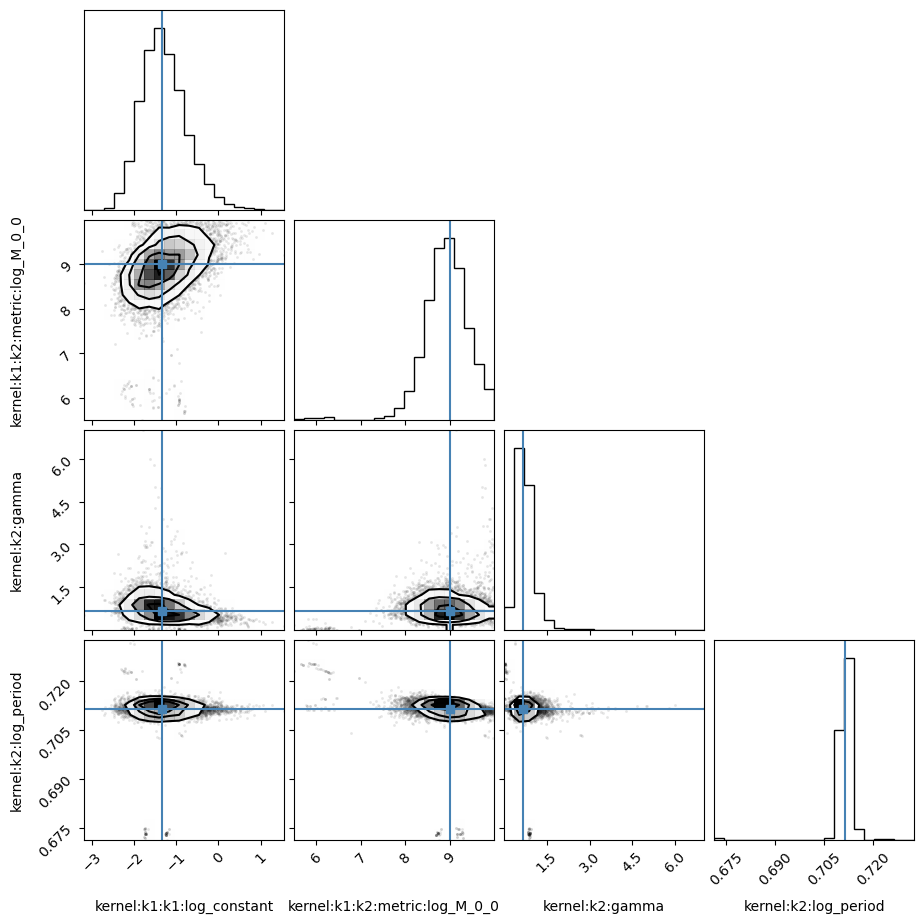

In [28]:
samples = sampler.get_chain(discard=100, thin=15, flat=True)

figure = corner.corner(samples, labels=gp.get_parameter_names(), truths=optimized_parameters)

# Mean and covariance of the samples can be used to initialize the GP.
gp_mean = np.median(samples, axis=0)
gp.set_parameter_vector(gp_mean)


print("Pre Mean Hyperparameters:")
print("Amplitude (A):", np.exp(gp_mean[0]))
print("Decay Timescale (l):", np.sqrt(np.exp(gp_mean[1])))
print("Periodic Amplitude (Gamma):", np.exp(gp_mean[2]))
print("Period (P):", np.exp(gp_mean[3]))

### Visualise GP

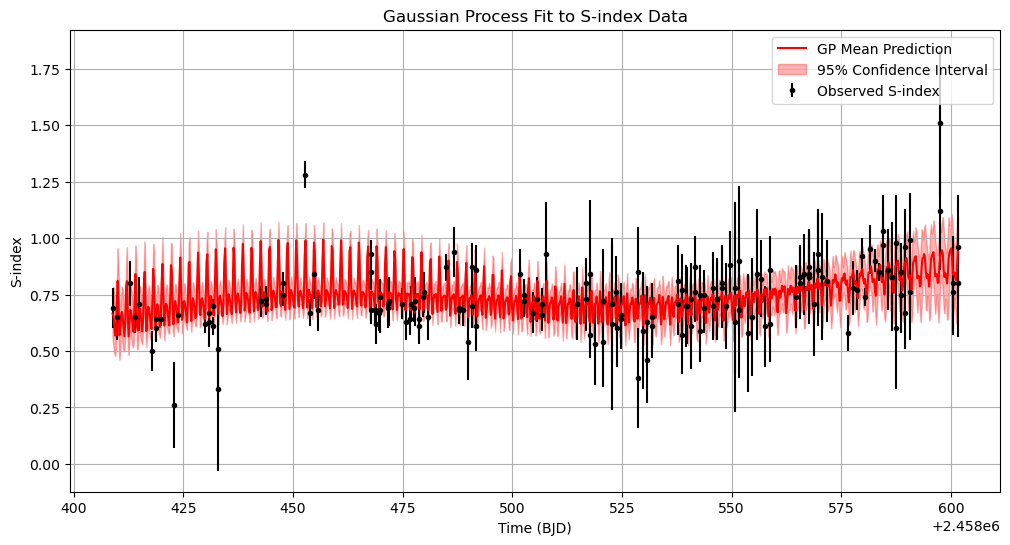

In [29]:
# Prediction points
t_pred = np.linspace(min(time), max(time), 1000)  # 1000 points for smoothness
mean, cov = gp.predict(s_index_values, t_pred, return_cov=True)  # Mean and covariance of the prediction
std = np.sqrt(np.diag(cov))  # Standard deviation at each predicted point

# Plot
plt.figure(figsize=(12, 6))
plt.errorbar(time, s_index_values, yerr=s_index_error, fmt=".k", capsize=0, label='Observed S-index')
plt.plot(t_pred, mean, 'r', lw=1.5, label='GP Mean Prediction')
plt.fill_between(t_pred, mean - 1.96 * std, mean + 1.96 * std, color='red', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Time (BJD)')
plt.ylabel('S-index')
plt.title('Gaussian Process Fit to S-index Data')
plt.legend()
plt.grid(True)
plt.show()

## Hierarchical model

In [30]:
import numpy
print(numpy.__version__)

1.22.1


In [31]:
import pymc3 as pm
import numpy as np
from pymc3.gp.cov import ExpQuad, Periodic

In [47]:
A_harp, A_post, A_pre = np.exp(gp_mean[0]), np.exp(gp_mean_post[0]), np.exp(gp_mean_pre[0])
l_harp, l_post, l_pre = np.sqrt(np.exp(gp_mean[1])), np.sqrt(np.exp(gp_mean_post[1])), np.sqrt(np.exp(gp_mean_pre[1]))
Gamma_harp, Gamma_post, Gamma_pre = np.exp(gp_mean[2]), np.exp(gp_mean_post[2]), np.exp(gp_mean_pre[2])
P_harp, P_post, P_pre = np.exp(gp_mean[3]), np.exp(gp_mean_post[3]), np.exp(gp_mean_pre[3])

A_values = np.array([A_harp, A_post, A_pre])
l_values = np.array([l_harp, l_post, l_pre])
Gamma_values = np.array([Gamma_harp, Gamma_post, Gamma_pre])
P_values = np.array([P_harp, P_post, P_pre])

A_mean, A_std = np.mean(A_values), np.std(A_values)
l_mean, l_std = np.mean(l_values), np.std(l_values)
Gamma_mean, Gamma_std = np.mean(Gamma_values), np.std(Gamma_values)
P_mean, P_std = np.mean(P_values), np.std(P_values)

In [48]:
A_mean, A_std, l_mean, l_std, Gamma_mean, Gamma_std, P_mean, P_std

(0.24628668157535946,
 0.015593637552946163,
 62.61272048037182,
 21.927077560208026,
 3.7812971419074413,
 1.336933416149152,
 3.018572779711731,
 1.8181303630891201)

In [39]:
A_mean, A_std, l_mean, l_std, Gamma_mean, Gamma_std, P_mean, P_std = (
0.24628668157535946,
 0.015593637552946163,
 62.61272048037182,
 21.927077560208026,
 3.7812971419074413,
 1.336933416149152,
 3.018572779711731,
 1.8181303630891201)

/Users/maxtalberg/miniconda3/envs/rv-env/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


/var/folders/2g/9t7c77957pl9vb9x2t79vs2c0000gn/T/ipykernel_98731/3726432847.py:54: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/Users/maxtalberg/miniconda3/envs/rv-env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>],
       [<Axes: title={'center': 'ls'}>, <Axes: title={'center': 'ls'}>],
       [<Axes: title={'center': 'offset_pre'}>,
        <Axes: title={'center': 'offset_pre'}>],
       [<Axes: title={'center': 'offset_post'}>,
        <Axes: title={'center': 'offset_post'}>],
       [<Axes: title={'center': 'offset_harps'}>,
        <Axes: title={'center': 'offset_harps'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'period'}>,
        <Axes: title={'center': 'period'}>],
       [<Axes: title={'center': 'sigma_pre'}>,
        <Axes: title={'center': 'sigma_pre'}>],
       [<Axes: title={'center': 'sigma_post'}>,
        <Axes: title={'center': 'sigma_post'}>],
       [<Axes: title={'center': 'sigma_harps'}>,
        <Axes: title={'center': 'sigma_harps'}>]], dtype=object)

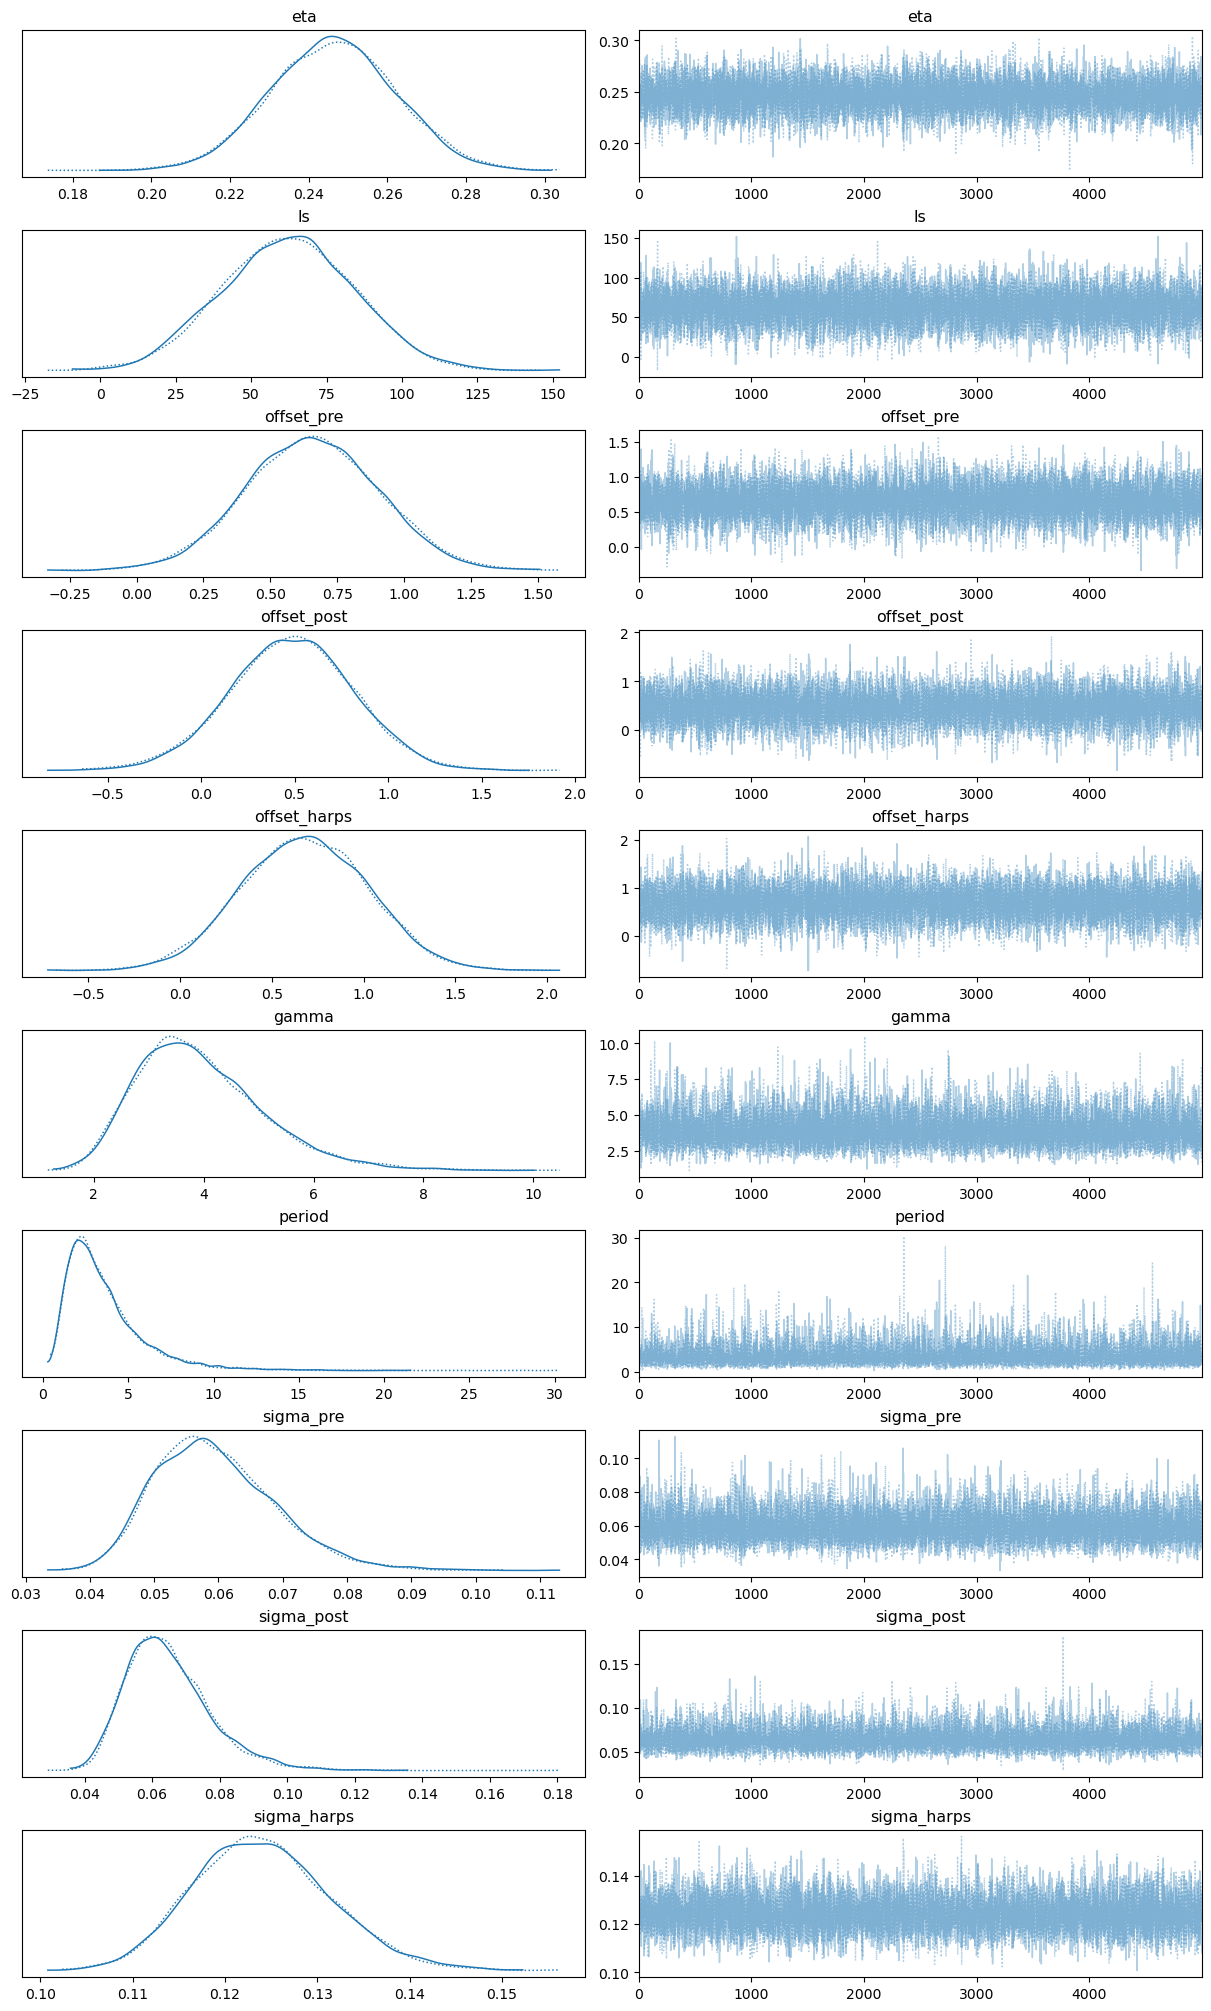

In [49]:
# Load the data
# ESPRESSO pre
time_pre = df_pre['Time'].values
s_index_values_pre = df_pre['Sindex'].values
s_index_error_pre = df_pre['e_Sindex'].values

# ESPRESSO post
time_post = df_post['Time'].values
s_index_values_post = df_post['Sindex'].values
s_index_error_post = df_post['e_Sindex'].values

# HARPS
time_harps = harps_df['Time'].values
s_index_values_harps = harps_df['Sindex'].values
s_index_error_harps = harps_df['e_Sindex'].values

# setup pymc3 hierarchical model
with pm.Model() as hierarchial_gp_model:
    # shared hyperparams
    eta = pm.Normal('eta', mu=A_mean, sd=A_std) # Amplitude
    ls = pm.Normal('ls', mu=l_mean, sd=l_std)  # Decay Timescale
    gamma = pm.Lognormal('gamma', mu=np.log(Gamma_mean), sd=np.log(Gamma_std))  # Periodic Amplitude
    period = pm.Lognormal('period', mu=np.log(P_mean), sd=np.log(P_std))  # Period

    # Offset parameters
    offset_pre = pm.Normal('offset_pre', mu=0, sd=1)  # SPRESSO pre
    offset_post = pm.Normal('offset_post', mu=0, sd=1)  # ESPRESSO post
    offset_harps = pm.Normal('offset_harps', mu=0, sd=1)  # HARPS

    # Define the covariance function
    cov_pre = A_pre * ExpQuad(1, l_pre) * Periodic(1, P_pre, Gamma_pre) # ESPRESSO pre
    cov_post = A_post * ExpQuad(1, l_post) * Periodic(1, P_post, Gamma_post) # ESPRESSO post
    cov_harps = A_harp * ExpQuad(1, l_harp) * Periodic(1, P_harp, Gamma_harp) # HARPS

    # GP marginal likelihoods
    gp_pre = pm.gp.Marginal(cov_func=cov_pre)
    gp_post = pm.gp.Marginal(cov_func=cov_post)
    gp_harps = pm.gp.Marginal(cov_func=cov_harps)
    
    # noise term
    sigma_pre = pm.HalfNormal('sigma_pre', sigma=1)
    sigma_post = pm.HalfNormal('sigma_post', sigma=1)
    sigma_harps = pm.HalfNormal('sigma_harps', sigma=1)

    # GP marginal likelihoods
    y_pre_ = gp_pre.marginal_likelihood('y_pre', X=time_pre[:, None], y=s_index_values_pre - offset_pre, noise=sigma_pre)
    y_post_ = gp_post.marginal_likelihood('y_post', X=time_post[:, None], y=s_index_values_post - offset_post, noise=sigma_post)
    y_harps_ = gp_harps.marginal_likelihood('y_harps', X=time_harps[:, None], y=s_index_values_harps - offset_harps, noise=sigma_harps)

    # MCMC sampling
    trace = pm.sample(5000, cores=1, return_inferencedata=False, init='adapt_diag', tune=1000, target_accept=0.95)


pm.traceplot(trace)


In [50]:
pm.summary(trace)

/Users/maxtalberg/miniconda3/envs/rv-env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
eta,0.246,0.016,0.217,0.276,0.000,0.000,19630.0,19630.0,19679.0,7070.0,1.0
ls,62.401,21.988,20.903,102.538,0.182,0.140,14553.0,12296.0,14607.0,7823.0,1.0
offset_pre,0.656,0.248,0.183,1.108,0.002,0.001,20199.0,15762.0,20193.0,7246.0,1.0
offset_post,0.481,0.332,-0.144,1.107,0.003,0.002,15301.0,9559.0,15265.0,7337.0,1.0
offset_harps,0.678,0.343,0.006,1.282,0.003,0.002,15846.0,11971.0,15844.0,7534.0,1.0
gamma,3.952,1.162,1.966,6.103,0.009,0.007,16097.0,12225.0,18405.0,7192.0,1.0
period,3.593,2.352,0.527,7.695,0.023,0.018,10836.0,8163.0,13491.0,8046.0,1.0
sigma_pre,0.060,0.009,0.043,0.077,0.000,0.000,14582.0,12823.0,16454.0,7010.0,1.0
sigma_post,0.065,0.013,0.043,0.088,0.000,0.000,12136.0,10108.0,14665.0,7186.0,1.0
sigma_harps,0.124,0.007,0.110,0.138,0.000,0.000,15913.0,15542.0,16246.0,7938.0,1.0
